## Import libraries

In [1]:
# import numpy library for numerical computations
import numpy as np
# import pandas library for data manipulation and analysis
import pandas as pd

# import matplotlib library for plotting graphs
import matplotlib.pyplot as plt
# use magic command to display plots inline in Jupyter notebooks
%matplotlib inline
# import seaborn library for statistical data visualization
import seaborn as sns

# ignore warnings from libraries or Python runtime
import warnings
warnings.filterwarnings('ignore')

## Read the dataset

In [2]:
# read the csv file containing the heart disease data and store it in a dataframe
real_df = pd.read_csv("Data set 1 (12 KB) - heart_disease.csv")

# make a deep copy of the original dataframe to avoid modifying it
df = real_df.copy(deep=True)

# drop the duplicate rows from the copied dataframe
df = df.drop_duplicates()

# print the shape of the original and copied dataframes to compare
print("before dropping : ", real_df.shape)
print("after dropping : ", df.shape)

before dropping :  (303, 14)
after dropping :  (302, 14)


# Remove outliers in the dataset

In [3]:
def detect_outliers(data):
    """
    Detect outliers in the given data using the z-score method.

    Args:
    - data: The data to be checked for outliers (pandas Series).

    Returns:
    - outliers: A list containing the outlier values.
    """
    # initialize an empty list to store the outliers
    outliers = []
    # set a threshold value for the z-score
    threshold = 3
    # calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # loop through each element in the data
    for i in data:
        # calculate the z-score of the element
        z_score = (i - mean) / std
        # check if the z-score is above or below the threshold
        if np.abs(z_score) > threshold:
            # add the element to the outliers list
            outliers.append(i)
    # return the outliers list
    return outliers

# initialize an empty list to store the columns with outliers and their values
z_outliers = []

# loop through each column in the dataframe
for column in df.columns:
    # check if the column has outliers 
    if detect_outliers(df[column]) != [] and detect_outliers(df[column]) != [0, 0]:
        # store the columns with outliers and the outlier values in a tuple
        z_outliers.append((column, detect_outliers(df[column])))

# print the shape of the dataframe before removing outliers
print("Before removing outliers:", df.shape)

# loop through each tuple in the z_outliers list
for feature, outliers_list in z_outliers:
    # remove the rows that contain the outlier values from the dataframe
    df = df[~df[feature].isin(outliers_list)]

# print the shape of the dataframe after removing outliers
print("After removing outliers:", df.shape)

Before removing outliers: (302, 14)
After removing outliers: (289, 14)


EDA
===

### Visualizing Pearson correlation

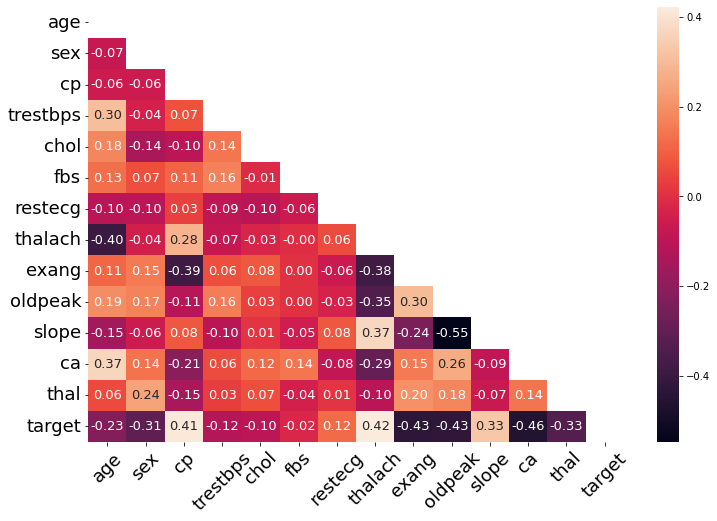

In [4]:
# create a figure with a specified size
plt.figure(figsize=(12, 8))

# calculate the correlation matrix of the dataframe
corr = df.corr()
# create a mask to hide the upper triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
# apply the mask to the correlation matrix
masked_corr = corr.mask(mask)
# plot a heatmap of the masked correlation matrix with annotations and formatting
sns.heatmap(masked_corr, annot=True, annot_kws={"size": 13}, fmt='.2f') 

# set the font size and rotation of the x-axis labels
plt.xticks(fontsize=18, rotation=45)
# set the font size of the y-axis labels
plt.yticks(fontsize=18)

# show the plot
plt.show()

### Visualizing Heart Disease Presence

<Figure size 720x432 with 0 Axes>

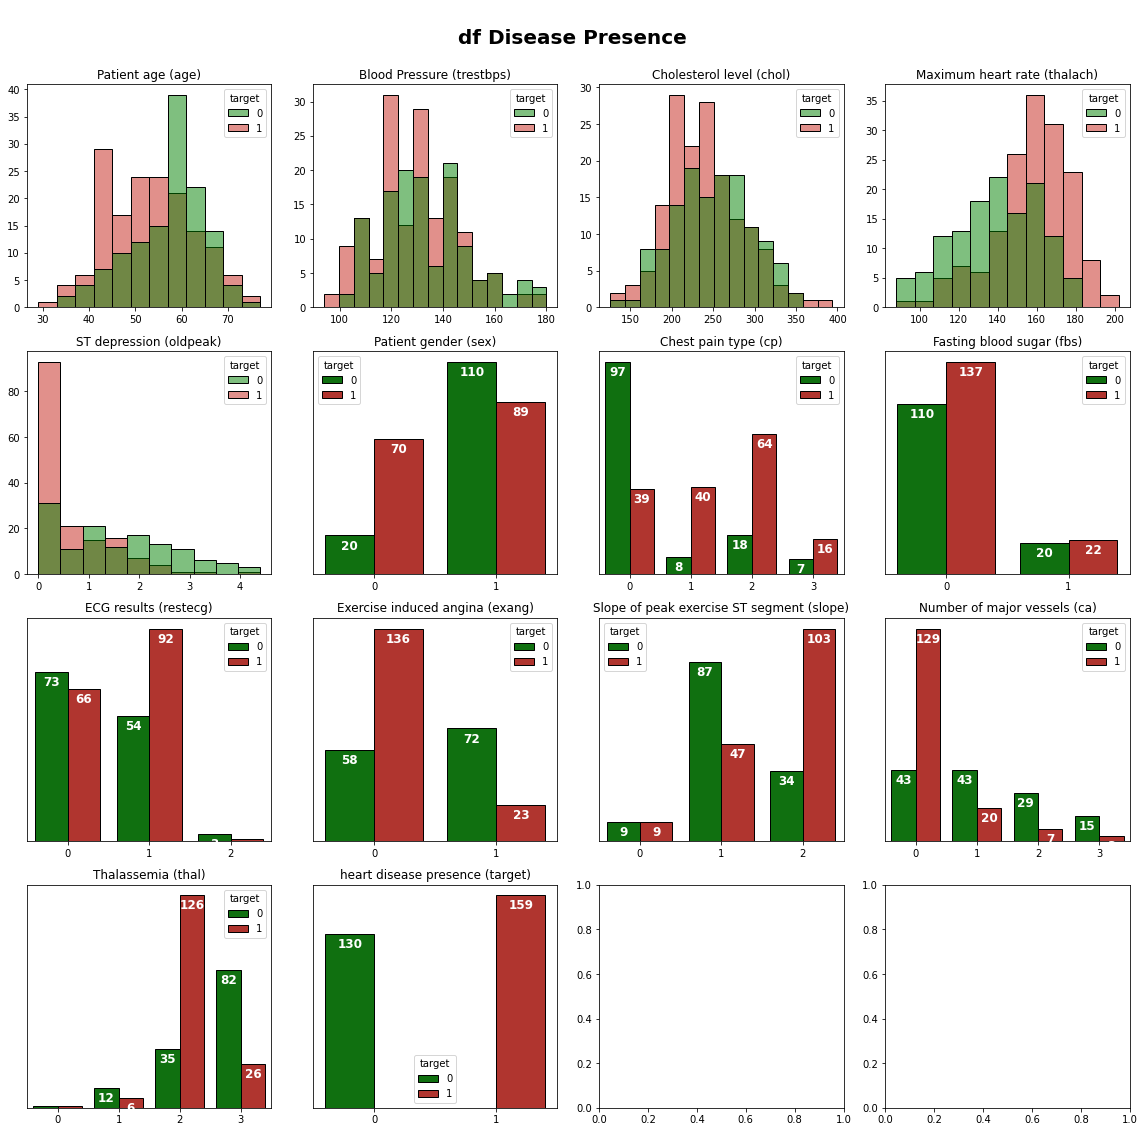

In [5]:

# Add a legend for the entire subplot
plt.figure(figsize=(10, 6))

# Define the columns to analyze
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Define the column descriptions
descriptions = {
    'age': 'Patient age (age)',
    'trestbps': 'Blood Pressure (trestbps)',
    'chol': 'Cholesterol level (chol)',
    'thalach': 'Maximum heart rate (thalach)',
    'oldpeak': 'ST depression (oldpeak)',
    'sex': 'Patient gender (sex)',
    'cp': 'Chest pain type (cp)',
          'fbs': 'Fasting blood sugar (fbs)',
          'restecg': 'ECG results (restecg)',
          'exang': 'Exercise induced angina (exang)',
          'slope': 'Slope of peak exercise ST segment (slope)',
          'ca': 'Number of major vessels (ca)',
          'thal': 'Thalassemia (thal)',
          'target': 'heart disease presence (target)'
}

# Create a figure with subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('\ndf Disease Presence\n', fontsize=20, fontweight='bold')

# Define the color palette
palette = {0: 'green', 1: '#C52219'}

# Loop through the columns and plot the charts
for i, cols in enumerate(descriptions.keys()):
    # Get the row and column index of the subplot
    row = i // 4
    col = i % 4

    # Check if the column should use histplot or barplot
    if cols in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        # Plot the histplot with seaborn
        sns.histplot(data=df, x=cols, hue="target", ax=axes[row][col], palette=palette)
    else:
        # Plot the countplot with seaborn
        sns.countplot(data=df, x=cols, hue="target", ax=axes[row][col], palette=palette, linewidth=1, edgecolor='black')
        
        # Turn off the y-axis
        axes[row][col].get_yaxis().set_visible(False)

        # Add annotations to the countplot
        for p in axes[row][col].patches:
            axes[row][col].annotate(format(p.get_height(), '.0f'),
                                    (p.get_x() + p.get_width() / 2., p.get_height()),
                                    ha='center', va='center',
                                    xytext=(0, -10),
                                    textcoords='offset points',
                                    color='white',
                                    fontsize=12,
                                    fontweight='bold')

    # Set the title and labels
    axes[row][col].set_title(descriptions[cols])
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

# Feature selection using Pearson correlation
Result :
* `more_important_features`
* `less_important_features`

In [6]:
# Calculate correlation between features and target variable
correlationranking = df.corr().abs()['target'].sort_values(ascending=False)

# Extract more important features with correlation greater than 0.2
more_important_features = correlationranking[correlationranking > 0.2].drop('target')
more_important_features = more_important_features.index.tolist()

# Extract less important features with correlation less than 0.2
less_important_features = correlationranking[correlationranking < 0.2]
less_important_features = less_important_features.index.tolist()


## Feature selection using sklearn
Result :
* `feature_selection`

In [7]:
# feature selection with sklearn

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# List to store collected features
collected_features = []

# Function to get the features
def getFeatures(selector):
    """
    Fits the selector on the data and collects the selected features.
    
    Args:
    - selector: The feature selection selector object
    
    Returns:
    - None
    """
    # Fit the selector on the data
    selector.fit(X, y)

    # Get the list of features based on column index
    selected_features = X.columns[selector.get_support(indices=True)].tolist()

    # Add selected features to collected_features list
    collected_features.extend(selected_features)


# 1) Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Pick only 5 features with the highest f_classif score
selector = SelectKBest(f_classif, k=5)

getFeatures(selector)


# 2) Recursive feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create the RFE with a LogisticRegression estimator and 5 features to select
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5, step=1)

getFeatures(selector)


# 3) Tree-based feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Create and fit the ExtraTreesClassifier with feature selection
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=65), max_features=5)

getFeatures(selector)


# 4) L1-based (lasso) feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Perform feature selection using L1-based feature selection
selector = SelectFromModel(LinearSVC(penalty='l1', dual=False), max_features=5)

getFeatures(selector)


# Count and sort the features by their occurrence
feature_counts = pd.Series(collected_features).value_counts()

* ### Conclude all sklearn feature selection methods by counting the number of times a feature was selected

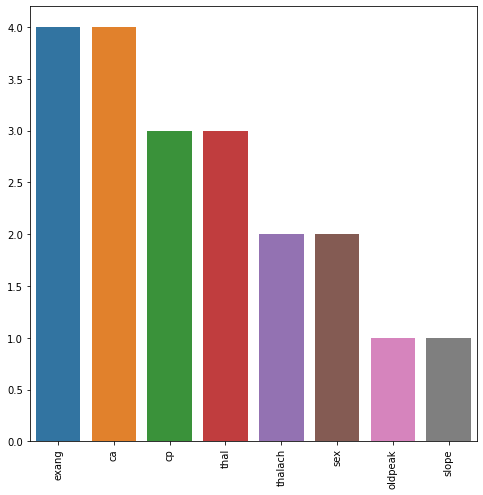

In [8]:
# count and sort the features by their occurence
feature_counts = pd.Series(collected_features).value_counts()

# Plot the result
plt.figure(figsize=(8,8))
sns.barplot(x=feature_counts.index, y=feature_counts.values)
plt.xticks(rotation=90)
plt.show()


In [9]:
# Create a list of feature selections with corresponding feature sets
feature_selection = [("all features in dataset", sorted(df.columns[:13].tolist())),
                     ("more_important_features", sorted(more_important_features)),
                     ("less_important_features", sorted(less_important_features)),
                     ("all_sklearn_features", sorted(feature_counts.index.tolist())),
                     ("top5_sklearn_features", sorted(feature_counts.index.tolist()[:5]))]

# Iterate over the feature_selection list and print the feature selection name and corresponding feature set
for x, y in feature_selection:
    print(x, " : ", y)

all features in dataset  :  ['age', 'ca', 'chol', 'cp', 'exang', 'fbs', 'oldpeak', 'restecg', 'sex', 'slope', 'thal', 'thalach', 'trestbps']
more_important_features  :  ['age', 'ca', 'cp', 'exang', 'oldpeak', 'sex', 'slope', 'thal', 'thalach']
less_important_features  :  ['chol', 'fbs', 'restecg', 'trestbps']
all_sklearn_features  :  ['ca', 'cp', 'exang', 'oldpeak', 'sex', 'slope', 'thal', 'thalach']
top5_sklearn_features  :  ['ca', 'cp', 'exang', 'thal', 'thalach']


### Exhaustive Feature Selection (using all possible combinations of features)

In [10]:
from itertools import combinations

def generate_combinations(df):
    """
    Generate combinations of features from the given DataFrame.

    Args:
    - df: The DataFrame containing the features.

    Returns:
    - all_combinations: A list of tuples, where each tuple contains a string representation 
                        and a sorted list of a feature combination.
    """
    features = df.columns[:13]  # Select the first 13 columns as features

    # Generate all possible combinations of features using itertools.combinations
    all_combinations = [
        (', '.join(sorted(combination)), sorted(combination)) 
        for r in range(1, len(features) + 1) 
        for combination in combinations(features, r)
    ]
    
    return all_combinations

# Generate all combinations of features from the DataFrame
features = generate_combinations(df)

# Print the number of generated combinations
print(len(features))

8191


## Create function to split and transform data

In [11]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_test_data(df, features):
    """
    Split the data into training and testing sets and perform standard scaling on the features.

    Args:
    - df: The DataFrame containing the data.
    - features: The list of feature columns.

    Returns:
    - X_train: The training set of features.
    - X_test: The testing set of features.
    - y_train: The training set of target variable.
    - y_test: The testing set of target variable.
    """
    X = df[features]  # Select the specified features from the DataFrame

    y = df['target']  # Select the target variable

    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # scale the data using standard scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## Create function to train and evaluate the 3 models

In [12]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

def training_models(X_train, X_test, y_train, y_test):
    """
    Train multiple classification models and evaluate their performance.

    Args:
    - X_train: The training set of features.
    - X_test: The testing set of features.
    - y_train: The training set of target variable.
    - y_test: The testing set of target variable.

    Returns:
    - results: A pandas DataFrame containing the model names and their corresponding accuracy scores.
    """
    models = [
        ("KNN", KNeighborsClassifier()),  # K-Nearest Neighbors classifier model
        ("Naive Bayes Bernoulli", BernoulliNB()),  # Bernoulli Naive Bayes classifier model
        ("SVM", SVC())  # Support Vector Machine classifier model
    ]

    results = []  # Initialize an empty list to store the results

    # Loop through each model and fit, predict, and score
    for name, model in models:
        print(f"Now training {name} model")  # Print the current model being trained

        model.fit(X_train, y_train)  # Fit the model to the training data
        accuracy = model.score(X_test, y_test)  # Evaluate the model accuracy on the testing data
        
        results.append({"model": name, "accuracy": accuracy})  # Add the model name and accuracy to the results list

    return pd.DataFrame(results)  # Return the results as a pandas DataFrame

## Evaluate the accuracy score of the all features combination in Exhaustive Feature Selection

In [13]:
combination_accuracy = pd.DataFrame()  # Create an empty DataFrame to store the combination accuracy results

print("remove by zscore")
for desc, cols in features:
    # Iterate through each combination of features
    print(f"\ntraining models for features: {desc}")  # Print the description of the current feature combination

    # Train models and obtain the accuracy summary using the current feature combination
    training_summary = training_models(*train_test_data(df, cols))

    # Add a new column to the accuracy summary DataFrame to store the description of the feature combination
    training_summary['features'] = desc

    # Append the accuracy summary for the current feature combination to the combination_accuracy DataFrame
    combination_accuracy = combination_accuracy.append(training_summary)

remove by zscore

training models for features: age
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: sex
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: cp
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: trestbps
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: chol
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: fbs
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: restecg
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM model

training models for features: thalach
Now training KNN model
Now training Naive Bayes Bernoulli model
Now training SVM 

## Evaluate how well these features fare among all the features in Exhuaustive Feature Selection 
* `all features in dataset`
* `more_important_features`
* `less_important_features`
* `all_sklearn_features`
* `top5_sklearn_features`

In [14]:
combination_accuracy = combination_accuracy.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

matching = pd.DataFrame()

# Iterate over feature selection descriptions and corresponding columns
for desc, columns in feature_selection:
    print("Now matching for features : ", desc)
    match = ', '.join(columns)
    
    # Filter the combination accuracy dataframe by the match and assign the description column
    match_df = combination_accuracy[combination_accuracy['features'] == match].assign(description=desc)
    
    # Append the match dataframe to the matching dataframe
    matching = matching.append(match_df)
    
# Replace accuracy column with the max accuracy for each description
grouped = matching.groupby('description')['accuracy'].transform(max)

# Filter the DataFrame to include only the rows with the highest accuracy for each description
max_accuracy_rows = matching[matching['accuracy'] == grouped]

# Sort the DataFrame by accuracy in descending order
max_accuracy_rows.sort_values(by='accuracy', ascending=False, inplace=True)

# The resulting DataFrame contains rows with the highest accuracy for each description
max_accuracy_rows

Now matching for features :  all features in dataset
Now matching for features :  more_important_features
Now matching for features :  less_important_features
Now matching for features :  all_sklearn_features
Now matching for features :  top5_sklearn_features


,model,accuracy,features,description
47,SVM,0.931034,"age, ca, chol, cp, exang, fbs, oldpeak, restec...",all features in dataset
184,SVM,0.931034,"ca, cp, exang, oldpeak, sex, slope, thal, thalach",all_sklearn_features
3343,Naive Bayes Bernoulli,0.879310,"age, ca, cp, exang, oldpeak, sex, slope, thal,...",more_important_features
3356,SVM,0.879310,"age, ca, cp, exang, oldpeak, sex, slope, thal,...",more_important_features
2086,SVM,0.879310,"ca, cp, exang, thal, thalach",top5_sklearn_features
24389,Naive Bayes Bernoulli,0.637931,"chol, fbs, restecg, trestbps",less_important_features


## The top 5 best features in Exhaustive Feature Selection

In [15]:
# show the top 5 highest accuracy feeature combinations
combination_accuracy.head(5)

,model,accuracy,features
0,SVM,0.965517,"ca, chol, cp, exang, oldpeak, restecg, sex, sl..."
1,SVM,0.965517,"ca, chol, cp, oldpeak, restecg, sex, slope, th..."
2,SVM,0.948276,"ca, cp, exang, oldpeak, restecg, sex, slope, t..."
3,SVM,0.948276,"age, ca, cp, oldpeak, restecg, slope, thal"
4,Naive Bayes Bernoulli,0.948276,"ca, cp, exang, fbs, oldpeak, restecg, sex, slope"


## Store the best features in Exhaustive Feature Selection into `best_features` 

In [16]:
# Select the best features from the 'combination_accuracy' dataframe by choosing the first row of the 'features' column
best_features = combination_accuracy['features'].head(1)

# Split the string values in 'best_features' by comma and convert it into a list
best_features = best_features.str.split(', ')

# Access the first element of the resulting list, which contains the individual feature names
best_features = best_features[0]

# Print the best_features list, which represents the selected features
print(best_features)

['ca', 'chol', 'cp', 'exang', 'oldpeak', 'restecg', 'sex', 'slope', 'thal', 'trestbps']


# Optimization

## Create function to perform optimization using GridSearchCV based on features and other parameters

In [17]:
import timeit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

# Create an empty DataFrame to store the results
df_Tuned = pd.DataFrame(columns=[['model', 'base accuracy', 'best accuracy', 'best_params', 'precision', 'recall', 'confusion matrix', 'training time']])

# Define a function for grid search model
def grid_search_model(name, model, param_grid, X_train, X_test, y_train, y_test):  
    
    # Print the current model being trained
    print(f"\nNow training {name} model")

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Print the start of tuning process
    print(f"Now tuning {name} model")

    # Measure the start time of the grid search
    startTimer = timeit.default_timer()

    # Perform grid search using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)

    # Fit the model on the scaled training data
    grid_search.fit(X_train, y_train)

    # Measure the stop time of the grid search
    stopTimer = timeit.default_timer()
    
    # Get the best model found by GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predict on the test data using the best estimator
    y_pred = best_model.predict(X_test)

    # Compute and store the results in a dictionary
    results = []
    results.append({
        "model": name,
        "base_accuracy" : model.score(X_test, y_test),
        "best_accuracy": best_model.score(X_test, y_test),
        "best_params": str(best_model),
        "precision": round(precision_score(y_test, y_pred), 6),
        "recall": round(recall_score(y_test, y_pred), 6),
        "confusion_matrix": str(confusion_matrix(y_test, y_pred)).replace('\n', ''),
        "training time": round(stopTimer - startTimer, 6)
    })

    # Convert the results to a DataFrame and return it
    return pd.DataFrame(results)

In [18]:
features_str = ', '.join(best_features)  # Joining the elements of the list 'best_features' into a string separated by commas
print(features_str)  # Printing the resulting string

ca, chol, cp, exang, oldpeak, restecg, sex, slope, thal, trestbps


### Finding the best K

Maximum accuracy: 0.9482758620689655 at K = 33


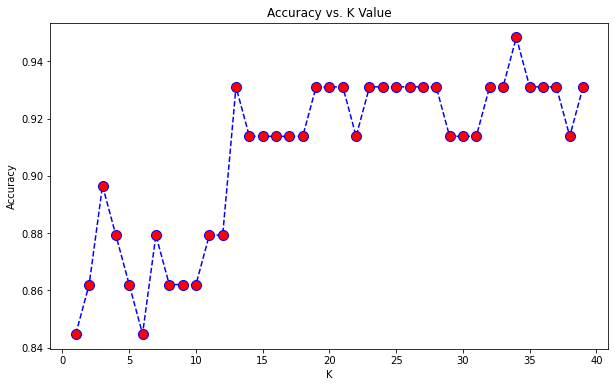

In [19]:
# Splitting the data into training and testing sets using the train_test_data function
X_train, X_test, y_train, y_test = train_test_data(df, best_features)

# Initializing an empty list to store accuracy values
acc = []

# Looping through different values of K (number of neighbors)
for i in range(1, 40):
    # Creating a K-Nearest Neighbors classifier with the current value of K
    model = KNeighborsClassifier(n_neighbors=i)
    # Training the model using the training data
    model.fit(X_train, y_train)
    # Predicting the labels for the test data
    y_pred = model.predict(X_test)
    # Calculating and appending the accuracy of the predictions to the accuracy list
    acc.append(accuracy_score(y_test, y_pred))
    
# Plotting the accuracy values against different values of K
plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), acc, color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

# Finding the index of the maximum accuracy in the accuracy list
best_K = acc.index(max(acc))

# Printing the maximum accuracy and the corresponding value of K
print("Maximum accuracy:", max(acc), "at K =", best_K)

## Specify the parameters to be tuned

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

# List of models with params to perform grid search on
models = [
    # K-Nearest Neighbors (KNN) model
    ("KNN", KNeighborsClassifier(),
        {'n_neighbors': [33],  # Number of neighbors to consider
         'weights': ['uniform', 'distance'],  # Weight function used in prediction
         'algorithm': ['auto', 'ball_tree', 'kd_tree'],  # Algorithm used to compute nearest neighbors
         'p': [1, 2, 3, 4]  # Power parameter for the Minkowski metric
        }),

    # Naive Bayes Bernoulli model
    ("Naive Bayes Bernoulli", BernoulliNB(),
        {'alpha': [0.1, 1, 10],  # Additive smoothing parameter
         'fit_prior': [True, False],  # Whether to learn class prior probabilities or not
         'binarize': [0.0, 0.5, 1.0]  # Threshold for binarizing features
        }),

    # Support Vector Machine (SVM) model
    ("SVM", SVC(),
        {'C': [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],  # Regularization parameter
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function used in the algorithm
         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
        })
]


## Tune the parameters

In [21]:
tuning_results = pd.DataFrame()

# Iterate over the models
for name, model, param_grid in models:
    print(f"\ntuning {name} model")
    
    # Perform grid search with specified parameters
    results = grid_search_model(name, model, param_grid, *train_test_data(df, best_features))
    
    # Append the results to the tuning_results dataframe
    tuning_results = tuning_results.append(results)


tuning KNN model

Now training KNN model
Now tuning KNN model
Fitting 5 folds for each of 24 candidates, totalling 120 fits

tuning Naive Bayes Bernoulli model

Now training Naive Bayes Bernoulli model
Now tuning Naive Bayes Bernoulli model
Fitting 5 folds for each of 18 candidates, totalling 90 fits

tuning SVM model

Now training SVM model
Now tuning SVM model
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [22]:
# Sort the results by best accuracy
tuning_results.sort_values(by='best_accuracy', ascending=False, ignore_index= True ,inplace=True)
tuning_results

,model,base_accuracy,best_accuracy,best_params,precision,recall,confusion_matrix,training time
0,KNN,0.862069,0.913793,"KNeighborsClassifier(n_neighbors=33, p=1, weig...",0.882353,0.967742,[[23 4] [ 1 30]],1.666959
1,SVM,0.965517,0.913793,"SVC(C=0.5, gamma=0.01)",0.882353,0.967742,[[23 4] [ 1 30]],0.613760
2,Naive Bayes Bernoulli,0.896552,0.896552,BernoulliNB(alpha=10),0.931034,0.870968,[[25 2] [ 4 27]],0.058286
